In [1]:
using Revise

using LinearAlgebra, Statistics, Rotations, ProgressMeter, Random, BenchmarkTools, StaticArrays, Dates, FileIO, StatsBase, Accessors

using GLMakie, CairoMakie
gl(args...; kwargs...) = GLMakie.activate!(args...; kwargs...);
cairo(args...; kwargs...) = CairoMakie.activate!(args...; kwargs...);
set_window_config!(float=false);
ProgressMeter.ijulia_behavior(:clear)

theme = Theme(Figure = (resolution = (1000,1000),), Volume = (algorithm = :iso, isovalue = 1.0, isorange = 0.9, colorrange = (0, 2)))
set_theme!(theme)

import REPL
REPL.REPLCompletions.latex_symbols["\\fig"] = "fig = Figure(); ax = Axis(fig[1,1])";
REPL.REPLCompletions.latex_symbols["\\angstrom"] = "Å";

In [2]:
using CUDA
CUDA.allowscalar(false)
import NPhotons as nph
includet("../utils2.jl")

In [3]:
qmax = 2.5
# o = nph.normalizeScattering(nph.AtomVolume(nph.spiral(20, m = 2, r = 5, h = 15), 1.0), nphotons = 1, qmax = qmax);
o = nph.normalizeScattering(nph.AtomVolume(nph.spiral(10, m = 1.5, r = 3, h = 10), 1.0), nphotons = 1, qmax = qmax);
gl(); window(volshow(o))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


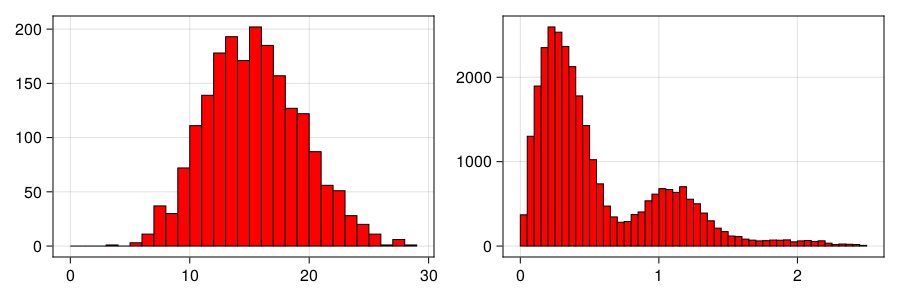

In [4]:
images = nph.generateImages(2000, 15, o)

cairo(); fig = Figure(resolution = (900, 300))
rs = 0:0.05:qmax
hist(fig[1,1], length.(images), bins=0:1:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=rs, color=:red, strokewidth=1, strokecolor=:black)
fig

In [5]:
params = nph.integrationParameters(qstep = 0.1, qmax = 2.5, npercircle = 32)
ev = nph.setupEval(params.rotations, params.pixels);

In [6]:
logp = nph.logpClosure(images, params.rotations, params.pixels, params.pixelWeights, params.npercircle, params.rotationWeights, 15)
grad = nph.gradientClosure(images, params.rotations, params.pixels, params.pixelWeights, params.npercircle, params.rotationWeights, 15);

In [7]:
f = deepcopy(o); f.positions .= randn.(SVector{3, Float64});
fs = [f]
ps = [-logp(f)];
f0=f;
fs0=fs;
ps0=ps;

In [8]:
gl(); fig = Figure(resolution = (1600, 1600))

# oe = -logp(o)
oe = 0
fnode = Observable(f)
enode = Observable(ps)
# Rnode = Observable(nph.align(f, o))
# on(fnode) do f
#     R = nph.align(Rnode[] * f, o, ntries = 10000)
#     Rnode[] = real.(R^0.01 * Rnode[])
# end

ax1 = Axis(fig[1,2])
lines!(ax1, lift(ps -> ps .- oe, enode))
hlines!(ax1, 0, color = :transparent)
on(s -> autolimits!(ax1), enode);

ls = LScene(fig[1,1][1,1], show_axis=false); Camera3D(ls.scene);
# volume!(ls, lift(f -> Rnode[] * f, fnode), algorithm = :iso)
volume!(ls, fnode, algorithm = :iso)

# ls = LScene(fig[1,1][1,2], show_axis=false); Camera3D(ls.scene);
# volume!(ls, o, algorithm = :iso, colormap = :ice)

linkCameras!(contents(fig[1, 1][:,:]))

window(fig)

In [9]:
function __comment()
Makie.record(fig, "gradientdescent1.webm", framerate = 30) do io
    @showprogress for t in 1:700
        ε = 1e-2
        g = map(1:length(f)) do i
            map(SA[1,2,3]) do j
                f2 = @set f.positions[i][j] += ε

                X = copy(ev(f));
                dX = (copy(ev(f2)) .- ev(f)) ./ ε;

                grad(X, dX)
            end
        end
        # g ./= norm(g)
        g

        f.positions .+= 0.0015g
        f.positions .-= Ref(mean(f.positions))

        fnode[] = f
        push!(fs, deepcopy(f))
        # push!(ps, -logp(f))
        push!(ps, norm(g))
        enode[] = enode[]

        ispressed(fig, Keyboard.escape) && break
        
        recordframe!(io)
    end
end
end

__comment (generic function with 1 method)

In [10]:
using PyCall
pushfirst!(PyVector(pyimport("sys")."path"), "")
samsara = pyimport("samsara")
# have to install the options and other samsara stuff?
function main()
ngrad_TOL = 6e-6   # eps**(1/3)
step_TOL = 4e-11   # eps**(2/3)
Maxit = 500
options = Dict()
options[:verbose] = true
options[:alpha_0] = 5e-12
options[:gamma] = .5
options[:c] = .01
options[:beta] = .9999999
options[:eta1] = .995
options[:eta2] = .8
options[:eta3] =  0.000001 # .025
options[:maxmem] = 8
options[:tr] = 1e+15
options[:ngrad_TOL] = ngrad_TOL
options[:step_TOL] = step_TOL
options[:Maxit] = Maxit
options[:QN_method] = samsara.BFGS1_product
options[:Step_finder] = samsara.Explicit_TR
options[:History] = samsara.cdSY_mat
options[:update_conditions] = "Trust Region"
options[:initial_step] = 1e+7*options[:step_TOL]

s = samsara.Samsara(;options...)



# initialize from the same initial state as the previous cell:
f_old=f0;
fs=fs0;
ps=ps0;
gl(); fig2 = Figure(resolution = (1600, 1600))

# initialize samsara:
E_old = -logp(f_old)
ε = 1e-2
g_old = map(1:length(f_old)) do i
    map(SA[1,2,3]) do j
        f2 = @set f_old.positions[i][j] += ε

        X = copy(ev(f_old));
        dX = (copy(ev(f2)) .- ev(f_old)) ./ ε;

        grad(X, dX)
    end
end

positions_new = nothing
E_new = nothing
f_new = nothing
g_new = nothing
stepsize = 999.
ngradf_new = 999.

# oe = -logp(o)
oe = 0
fnode = Observable(f_old)
enode = Observable(ps)

ax1 = Axis(fig2[1,2])
lines!(ax1, lift(ps -> ps .- oe, enode))
hlines!(ax1, 0, color = :transparent)
on(s -> autolimits!(ax1), enode);

ls = LScene(fig2[1,1][1,1], show_axis=false); Camera3D(ls.scene);
# volume!(ls, lift(f -> Rnode[] * f, fnode), algorithm = :iso)
volume!(ls, fnode, algorithm = :iso)

# ls = LScene(fig[1,1][1,2], show_axis=false); Camera3D(ls.scene);
# volume!(ls, o, algorithm = :iso, colormap = :ice)

linkCameras!(contents(fig2[1, 1][:,:]))

window(fig2)
function to_real_vect(b)
        if b == nothing
            return nothing
        end
        collect(Iterators.flatten(Iterators.flatten(b)))
end
function to_static_vect(b)
        b = reshape(b, :, 3)
        [SVector{3,Float64}(l...) for l in eachrow(b)]
end
    
Makie.record(fig2, "QuasiNewton.webm", framerate = 30) do io
    @showprogress for t in 1:100
        #  if we were in python, and samsara has been imported properly, the call to samsara in this context would look like:
        __a, __b, E_old, __c, stepsize = s.run(to_real_vect(f_old.positions), to_real_vect(positions_new), E_old, E_new, to_real_vect(g_old), to_real_vect(g_new))
        positions_new = to_static_vect(__a)
        f_old.positions .= to_static_vect(__b)
        g_old = to_static_vect(__c)
        # when positions_new and g_new are not None, then this overwrites f_old.positions on the left with 
        # positions_new from the right and overwrites g_old on the left with g_new from the right
        # and overwrites E_old on the left with N_new from the right...so none of these variables need to be updated
        # we just need to generate the new E_new and g_new and two replace .positions in f_new with positions_new
        
        # construct f_new: only the positions change, I think
        f_new=f_old
        # the next line is retained from Steffenś code above, but Iḿ not sure about this:
        # positions_new .-= Ref(mean(positions_new))
        f_new.positions.=positions_new
        

        # the next line evaluates the Energy at the new proposed positions
        E_new=-logp(f_new)
        
        # Now compute the gradient at the new positions
        ε = 1e-2
        g_new = map(1:length(f_new)) do i
            map(SA[1,2,3]) do j
                f2 = @set f_new.positions[i][j] += ε

                X = copy(ev(f_new));
                dX = (copy(ev(f2)) .- ev(f_new)) ./ ε;

                grad(X, dX)
            end
        end
        g_new .= -1g_new
        # Here, we could add a step acceptance criterion, but it is 
        # not really necessary, since samsara monitors whether E_new is 
        # less than E_old.
        
        fnode[] = f_new
        push!(fs, deepcopy(f_new))
        ngradf_new = norm(g_new)
        push!(ps, ngradf_new)
        enode[] = enode[]

        ispressed(fig2, Keyboard.escape) && break
        
        recordframe!(io)
    end
end
end
main()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


First iteration: initialising...
iteration: 0 ; trust region: 0.00039999999999999996 ; memory: -1
iteration: 0 ; trust region: 0.00039999999999999996 ; memory: 0
iteration: 0 ; trust region: 0.00019999999999999998 ; memory: 0
iteration: 0 ; trust region: 9.999999999999999e-05 ; memory: 0
iteration: 0 ; trust region: 4.9999999999999996e-05 ; memory: 0
iteration: 0 ; trust region: 2.4999999999999998e-05 ; memory: 0
iteration: 0 ; trust region: 1.2499999999999999e-05 ; memory: 0
iteration: 0 ; trust region: 6.2499999999999995e-06 ; memory: 0
iteration: 0 ; trust region: 3.1249999999999997e-06 ; memory: 0
iteration: 0 ; trust region: 1.5624999999999999e-06 ; memory: 0
iteration: 0 ; trust region: 7.812499999999999e-07 ; memory: 0
iteration: 0 ; trust region: 3.9062499999999997e-07 ; memory: 0
iteration: 0 ; trust region: 1.9531249999999998e-07 ; memory: 0
iteration: 0 ; trust region: 9.765624999999999e-08 ; memory: 0
iteration: 0 ; trust region: 4.8828124999999996e-08 ; memory: 0
iteration

"QuasiNewton.webm"